# Problem 4: Chip Placement Optimization using Integer Descent

We are given a grid $G$ of size $W \times H$. A set of tall rectangular chips must be placed:
- Each chip $c_i$ has width $w_i$, height $h_i$ with $h_i > w_i$.
- Each chip is **locked** to a fixed row $y_i$.
- Chips can only move **horizontally by integer steps**.

Additionally, some chips are connected through a **netlist**.

The objective is to arrange chips on the grid to **minimize the conflict score**.

---

## Conflict Score

$$
\text{Conflict}(P) = \sum_{(c_i,c_j)\in \text{Connections}} \text{WiringCost}(c_i,c_j) + \sum_{(c_i,c_j)\in \text{Overlaps}} \text{OverlapBlocks}(c_i,c_j)
$$

- **Wiring Cost**: Horizontal distance between connected chips.  
- **Overlap Penalty**: Number of overlapping cells if two chips collide.

---

## Optimization Approach

We apply **integer gradient descent**:

1. Start with an initial placement (chips aligned on their locked rows).  
2. For each chip, try shifting **left or right by 1 unit**.  
3. Accept the move if it **reduces conflict score**.  
4. Repeat until no chip can reduce the score further.  

This greedy descent ensures convergence to a **locally optimal placement**.

---

## Example (Conceptual)

- Grid width $W=10$.  
- Chips:  
  - $c_1$: width 2, height 4, row 2  
  - $c_2$: width 3, height 5, row 2  
- Connection: $(c_1, c_2)$.  

The algorithm shifts chips horizontally until overlap is removed and wiring cost is minimized.

CHIP PLACEMENT OPTIMIZATION USING INTEGER DESCENT

INITIAL STATE:
Initial Conflict Score: 40.0

Initial Chip Positions:
Chip ID | Position (x,y) | Size (w×h)
----------------------------------------
   c1   |    (0,0)     |   2×4
   c2   |    (1,1)     |   2×5
   c3   |    (1,0)     |   1×3
   c4   |    (2,4)     |   2×5
   c5   |    (3,3)     |   2×4
   c6   |    (2,2)     |   1×4
   c7   |    (0,5)     |   2×5
   c8   |    (4,6)     |   1×3

Initial Grid State:

Grid Visualization (rows y = 9 → 0):
y= 9 |   7   7   0   0   0   0   0   0   0   0
y= 8 |   7   7   4   4   8   0   0   0   0   0
y= 7 |   7   7   4   4   8   0   0   0   0   0
y= 6 |   7   7   4 4/5 5/8   0   0   0   0   0
y= 5 |   7 2/7 2/4/6 4/5   5   0   0   0   0   0
y= 4 |   0   2 2/4/6 4/5   5   0   0   0   0   0
y= 3 |   1 1/2 2/6   5   5   0   0   0   0   0
y= 2 |   1 1/2/3 2/6   0   0   0   0   0   0   0
y= 1 |   1 1/2/3   2   0   0   0   0   0   0   0
y= 0 |   1 1/3   0   0   0   0   0   0   0   0
        0   1   

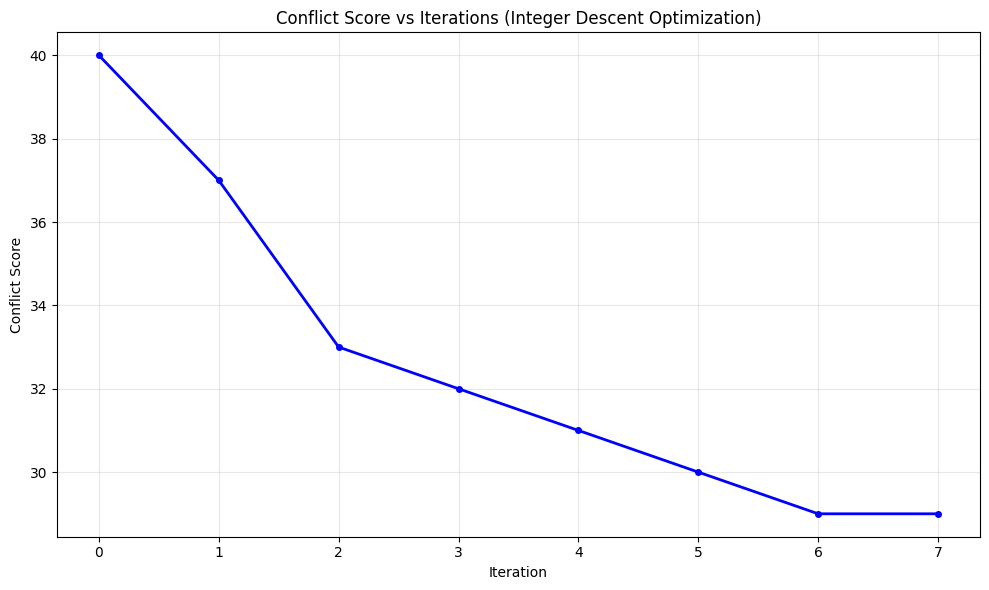


Optimization completed successfully!
Converged in 7 iterations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set
import copy

# Configuration (grid + chips)
GRID_WIDTH = 10
GRID_HEIGHT = 10

# chips as dicts: {'id': int, 'width': int, 'height': int, 'x': int, 'y': int}
chips: List[dict] = []

# connections as list of (id1, id2)
connections: List[Tuple[int, int]] = []

# Helper: add chips & connections
def add_chip(chip_id: int, width: int, height: int, x: int, y: int):
    chips.append({'id': chip_id, 'width': width, 'height': height, 'x': x, 'y': y})

def add_connection(c1: int, c2: int):
    connections.append((c1, c2))

def get_chip_by_id(chip_id: int) -> dict:
    for ch in chips:
        if ch['id'] == chip_id:
            return ch
    raise ValueError(f"Chip {chip_id} not found")

# Metrics: wiring cost & overlap
def calculate_wiring_cost(chip1: dict, chip2: dict) -> float:
    xi, wi = chip1['x'], chip1['width']
    xj, wj = chip2['x'], chip2['width']
    yi, yj = chip1['y'], chip2['y']

    # horizontal gap (0 if overlapping or abutting)
    horizontal_cost = max(0, xj - (xi + wi), xi - (xj + wj))
    vertical_cost = abs(yi - yj)
    return horizontal_cost + vertical_cost

def get_occupied_cells(chip: dict) -> Set[Tuple[int,int]]:
    cells = set()
    for dx in range(chip['width']):
        for dy in range(chip['height']):
            cells.add((chip['x'] + dx, chip['y'] + dy))
    return cells

def calculate_overlap_blocks(chip1: dict, chip2: dict) -> int:
    cells1 = get_occupied_cells(chip1)
    cells2 = get_occupied_cells(chip2)
    return len(cells1.intersection(cells2))

def calculate_total_conflict_score() -> float:
    total_score = 0.0
    # wiring costs (only for connected pairs)
    for c1, c2 in connections:
        ch1 = get_chip_by_id(c1)
        ch2 = get_chip_by_id(c2)
        total_score += calculate_wiring_cost(ch1, ch2)
    # overlaps (every unordered pair)
    for i in range(len(chips)):
        for j in range(i+1, len(chips)):
            total_score += calculate_overlap_blocks(chips[i], chips[j])
    return total_score

# Detailed breakdown (for final)
def calculate_detailed_conflict_breakdown() -> dict:
    breakdown = {
        'wiring_costs': {},
        'overlap_costs': {},
        'total_wiring': 0.0,
        'total_overlap': 0.0,
        'total_score': 0.0
    }
    for a,b in connections:
        ch1 = get_chip_by_id(a)
        ch2 = get_chip_by_id(b)
        cost = calculate_wiring_cost(ch1, ch2)
        key = (min(a,b), max(a,b))
        breakdown['wiring_costs'][key] = cost
        breakdown['total_wiring'] += cost

    for i in range(len(chips)):
        for j in range(i+1, len(chips)):
            ch1 = chips[i]
            ch2 = chips[j]
            blocks = calculate_overlap_blocks(ch1, ch2)
            if blocks > 0:
                key = (min(ch1['id'], ch2['id']), max(ch1['id'], ch2['id']))
                breakdown['overlap_costs'][key] = blocks
                breakdown['total_overlap'] += blocks

    breakdown['total_score'] = breakdown['total_wiring'] + breakdown['total_overlap']
    return breakdown

def print_detailed_conflict_breakdown():
    breakdown = calculate_detailed_conflict_breakdown()
    print(f"\nFinal Discrete Conflict Score: {int(breakdown['total_score'])}")
    print("\nDetailed Conflict Breakdown:")
    print("\tWiring Costs:")
    for (a,b), cost in sorted(breakdown['wiring_costs'].items()):
        if cost > 0:
            print(f"\t \tChips {a}-{b}: {int(cost)}")
    if breakdown['overlap_costs']:
        print("\tOverlap Costs:")
        for (a,b), blocks in sorted(breakdown['overlap_costs'].items()):
            print(f"\t \tChips {a}-{b}: {blocks} blocks")
    else:
        print("\tOverlap Costs:")
        print("\t  No overlaps found!")
    print(f"\nTotal Wiring Cost: {int(breakdown['total_wiring'])}")
    print(f"Total Overlap Cost: {int(breakdown['total_overlap'])}")
    print(f"Total Conflict Score: {int(breakdown['total_score'])}")

def create_grid_visualization() -> np.ndarray:
    grid = np.full((GRID_HEIGHT, GRID_WIDTH), "0", dtype=object)
    for ch in chips:
        for dx in range(ch['width']):
            for dy in range(ch['height']):
                gx = ch['x'] + dx
                gy = ch['y'] + dy
                if 0 <= gx < GRID_WIDTH and 0 <= gy < GRID_HEIGHT:
                    if grid[gy, gx] == "0":
                        grid[gy, gx] = str(ch['id'])
                    else:
                        existing = grid[gy, gx]
                        if "/" not in existing:
                            grid[gy, gx] = f"{existing}/{ch['id']}"
                        else:
                            grid[gy, gx] = f"{existing}/{ch['id']}"
    return grid

def print_grid():
    grid = create_grid_visualization()
    print("\nGrid Visualization (rows y = {} → 0):".format(GRID_HEIGHT-1))
    print("=" * (GRID_WIDTH * 4 + 5))
    for row in reversed(range(GRID_HEIGHT)):
        row_str = f"y={row:>2} |"
        for col in range(GRID_WIDTH):
            cell_content = str(grid[row, col])
            row_str += f" {cell_content:>3}"
        print(row_str)
    print("     " + "".join([f" {i:>3}" for i in range(GRID_WIDTH)]))
    print("     " + "   x=" + "".join([f"{i:>3}" for i in range(GRID_WIDTH)]))

def print_chip_positions(title="Chip Positions"):
    print(f"\n{title}:")
    print("Chip ID | Position (x,y) | Size (w×h)")
    print("-" * 40)
    for ch in sorted(chips, key=lambda c: c['id']):
        print(f"   c{ch['id']}   |    ({ch['x']},{ch['y']})     |   {ch['width']}×{ch['height']}")

def plot_conflict_history(history: List[float]):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(history)), history, 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Conflict Score')
    plt.title('Conflict Score vs Iterations (Integer Descent Optimization)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Integer-descent optimizer (procedural)
def is_valid_position(chip: dict, new_x: int) -> bool:
    return 0 <= new_x and new_x + chip['width'] <= GRID_WIDTH

def get_neighbors(chip: dict) -> List[int]:
    neighbors = []
    if is_valid_position(chip, chip['x'] - 1):
        neighbors.append(chip['x'] - 1)
    if is_valid_position(chip, chip['x'] + 1):
        neighbors.append(chip['x'] + 1)
    return neighbors

def integer_descent_step() -> bool:
    current_score = calculate_total_conflict_score()
    best_improvement = None
    best_chip_index = None
    best_new_x = None

    for idx, chip in enumerate(chips):
        for new_x in get_neighbors(chip):
            old_x = chip['x']
            chip['x'] = new_x
            new_score = calculate_total_conflict_score()
            improvement = current_score - new_score
            if improvement > 0 and (best_improvement is None or improvement > best_improvement):
                best_improvement = improvement
                best_chip_index = idx
                best_new_x = new_x
            # revert
            chip['x'] = old_x

    if best_improvement is not None and best_chip_index is not None:
        chips[best_chip_index]['x'] = best_new_x
        return True
    return False

def optimize(max_iterations: int = 100) -> List[float]:
    conflict_history: List[float] = []
    for iteration in range(max_iterations):
        current_score = calculate_total_conflict_score()
        conflict_history.append(current_score)
        print(f"Iteration {iteration}: Conflict Score = {current_score}")
        improved = integer_descent_step()
        if not improved:
            print(f"Converged after {iteration + 1} iterations")
            break
    # append final score
    final_score = calculate_total_conflict_score()
    conflict_history.append(final_score)
    return conflict_history

# Main (create chips, run optimizer)
def main():
    # populate chips (same input as your OOP example)
    chip_data = [
        (1, 2, 4, 0, 0),
        (2, 2, 5, 1, 1),
        (3, 1, 3, 1, 0),
        (4, 2, 5, 2, 4),
        (5, 2, 4, 3, 3),
        (6, 1, 4, 2, 2),
        (7, 2, 5, 0, 5),
        (8, 1, 3, 4, 6),
    ]
    for chip_id, width, height, x, y in chip_data:
        add_chip(chip_id, width, height, x, y)

    conns = [(1, 2), (2, 6), (2, 3), (3, 5), (4, 5), (5, 6), (1, 6), (7, 4), (7, 2), (8, 5)]
    for a,b in conns:
        add_connection(a, b)

    print("CHIP PLACEMENT OPTIMIZATION USING INTEGER DESCENT")
    print("=" * 60)

    print("\nINITIAL STATE:")
    initial_score = calculate_total_conflict_score()
    print(f"Initial Conflict Score: {initial_score}")
    print_chip_positions("Initial Chip Positions")
    print("\nInitial Grid State:")
    print_grid()

    print("\n" + "=" * 60)
    print("RUNNING INTEGER DESCENT OPTIMIZATION...")
    print("=" * 60)

    history = optimize(max_iterations=100)

    print("\n" + "=" * 60)
    print("FINAL RESULTS:")
    print("=" * 60)

    final_score = calculate_total_conflict_score()
    print(f"\nFinal Conflict Score: {final_score}")
    print(f"Total Improvement: {initial_score - final_score}")

    print_detailed_conflict_breakdown()
    print_chip_positions("Final Chip Positions")

    print("\nFinal Grid State:")
    print_grid()

    plot_conflict_history(history)

    print("\nOptimization completed successfully!")
    print(f"Converged in {len(history) - 1} iterations")

if __name__ == "__main__":
    main()
